In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from skimage import io as image_io
from torch import optim
import timm
from PIL import ImageEnhance, Image
from torchvision.transforms import v2
import cv2
from cv2 import kmeans, TERM_CRITERIA_MAX_ITER, TERM_CRITERIA_EPS, KMEANS_RANDOM_CENTERS
from matplotlib import pyplot as plt
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.cluster import KMeans
from randaugment.train.class_augmenters import bc, hed, hsv, morphology, FACTOR

d:\jswietek\mgr\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('../data/TCGA_breast_patch/expression_metadata.csv', index_col=0)
df['patch_id'] = df['file_name'].apply(lambda x: x.split('/')[3])
df['patient_id'] = df['patch_id'].apply(lambda x: x.split('_')[0])
df.set_index(['patient_id', 'file_name'], inplace=True)
df

label  \
patient_id            file_name                                                   
TCGA-3C-AALI-01A-01-T ../data/TCGA_breast_patch/TCGA-3C-AALI-01A-01-T...  HER2+   
                      ../data/TCGA_breast_patch/TCGA-3C-AALI-01A-01-T...  HER2+   
                      ../data/TCGA_breast_patch/TCGA-3C-AALI-01A-01-T...  HER2+   
                      ../data/TCGA_breast_patch/TCGA-3C-AALI-01A-01-T...  HER2+   
                      ../data/TCGA_breast_patch/TCGA-3C-AALI-01A-01-T...  HER2+   
...                                                                         ...   
TCGA-S3-AA17-01A-01-T ../data/TCGA_breast_patch/TCGA-S3-AA17-01A-01-T...    HR+   
                      ../data/TCGA_breast_patch/TCGA-S3-AA17-01A-01-T...    HR+   
                      ../data/TCGA_breast_patch/TCGA-S3-AA17-01A-01-T...    HR+   
                      ../data/TCGA_breast_patch/TCGA-S3-AA17-01A-01-T...    HR+   
                      ../data/TCGA_breast_patch/TCGA-S3-AA17-01A-01-T...    HR+   

                                                                                          patch_id  
patient_id            file_name                                                                     
TCGA-3C-AALI-01A-01-T ../data/TCGA_breast_patch/TCGA-3C-AALI-01A-01-T...  TCGA-3C-AALI-01A-01-T_R1  
                      ../data/TCGA_breast_patch/TCGA-3C-AALI-01A-01-T...  TCGA-3C-AALI-01A-01-T_R1  
                      ../data/TCGA_breast_patch/TCGA-3C-AALI-01A-01-T...  TCGA-3C-AALI-01A-01-T_R1  
                      ../data/TCGA_breast_patch/TCGA-3C-AALI-01A-01-T...  TCGA-3C-AALI-01A-01-T_R1  
                      ../data/TCGA_breast_patch/TCGA-3C-AALI-01A-01-T...  TCGA-3C-AALI-01A-01-T_R1  
...                                                                                            ...  
TCGA-S3-AA17-01A-01-T ../data/TCGA_breast_patch/TCGA-S3-AA17-01A-01-T...  TCGA-S3-AA17-01A-01-T_R2  
                      ../data/TCGA_breast_patch/TCGA-S3-AA17-01A-01-T...  TCGA-S3-AA17-01A-01-T_R2  
                      ../data/TCGA_breast_patch/TCGA-S3-AA17-01A-01-T...  TCGA-S3-AA17-01A-01-T_R2  
                      ../data/TCGA_breast_patch/TCGA-S3-AA17-01A-01-T...  TCGA-S3-AA17-01A-01-T_R2  
                      ../data/TCGA_breast_patch/TCGA-S3-AA17-01A-01-T...  TCGA-S3-AA17-01A-01-T_R2  

[714171 rows x 2 columns]

In [5]:
group_id = df.groupby(level=0).count()['label'] < 10
unique_patient_id = df.index.levels[0].unique()[group_id]
len(unique_patient_id)

28

<AxesSubplot:xlabel='label'>

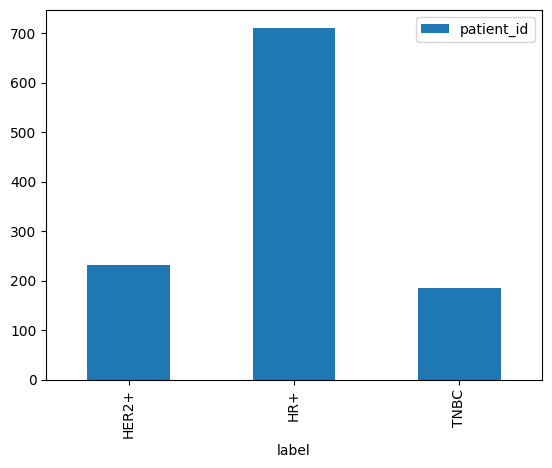

In [6]:
def get_patient_labels(df: pd.DataFrame):
    return pd.DataFrame([[p_id, df.loc[p_id].iloc[0, 0]] for p_id in df.index.get_level_values(0).unique()], columns=['patient_id', 'label'])
patient_labels_df = get_patient_labels(df)
patient_labels_df.groupby('label').count().plot.bar()

In [7]:
patient_labels_df

,patient_id,label
0,TCGA-3C-AALI-01A-01-T,HER2+
1,TCGA-5L-AAT0-01A-01-T,HR+
2,TCGA-A1-A0SE-01A-01-B,HR+
3,TCGA-A1-A0SF-01A-01-M,HR+
4,TCGA-A1-A0SF-01A-01-T,HR+
...,...,...
1123,TCGA-S3-AA11-01A-03-T,HR+
1124,TCGA-S3-AA12-01A-01-T,HR+
1125,TCGA-S3-AA14-01A-01-T,HER2+
1126,TCGA-S3-AA15-01A-01-T,TNBC


In [8]:
X_train, X_test, y_train, y_test = train_test_split(patient_labels_df['patient_id'], patient_labels_df['label'], test_size=0.2, random_state=42)

<AxesSubplot:>

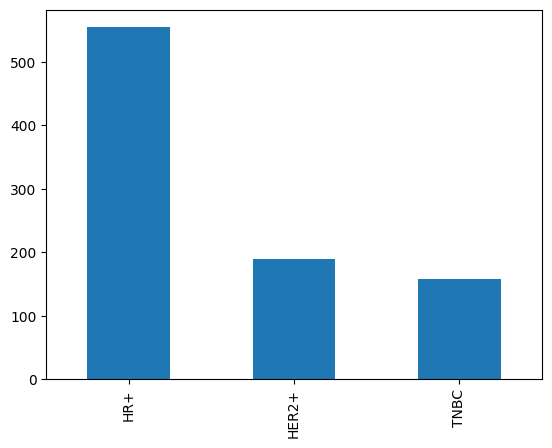

In [9]:
y_train.value_counts().plot.bar()

<AxesSubplot:>

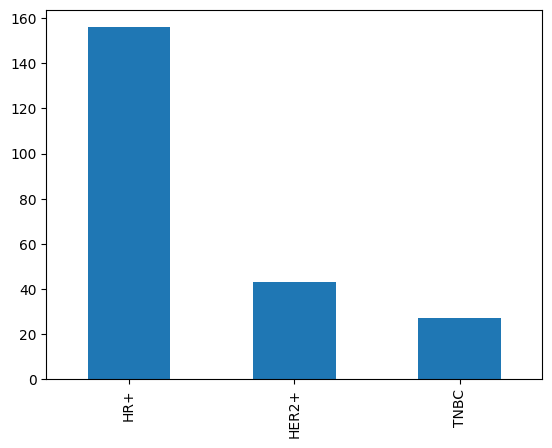

In [10]:
y_test.value_counts().plot.bar()

In [11]:
df.loc[X_train]

label  \
patient_id            file_name                                                  
TCGA-D8-A1XR-01A-01-T ../data/TCGA_breast_patch/TCGA-D8-A1XR-01A-01-T...   HR+   
                      ../data/TCGA_breast_patch/TCGA-D8-A1XR-01A-01-T...   HR+   
                      ../data/TCGA_breast_patch/TCGA-D8-A1XR-01A-01-T...   HR+   
                      ../data/TCGA_breast_patch/TCGA-D8-A1XR-01A-01-T...   HR+   
                      ../data/TCGA_breast_patch/TCGA-D8-A1XR-01A-01-T...   HR+   
...                                                                        ...   
TCGA-S3-AA15-01A-01-T ../data/TCGA_breast_patch/TCGA-S3-AA15-01A-01-T...  TNBC   
                      ../data/TCGA_breast_patch/TCGA-S3-AA15-01A-01-T...  TNBC   
                      ../data/TCGA_breast_patch/TCGA-S3-AA15-01A-01-T...  TNBC   
                      ../data/TCGA_breast_patch/TCGA-S3-AA15-01A-01-T...  TNBC   
                      ../data/TCGA_breast_patch/TCGA-S3-AA15-01A-01-T...  TNBC   

                                                                                          patch_id  
patient_id            file_name                                                                     
TCGA-D8-A1XR-01A-01-T ../data/TCGA_breast_patch/TCGA-D8-A1XR-01A-01-T...  TCGA-D8-A1XR-01A-01-T_R1  
                      ../data/TCGA_breast_patch/TCGA-D8-A1XR-01A-01-T...  TCGA-D8-A1XR-01A-01-T_R1  
                      ../data/TCGA_breast_patch/TCGA-D8-A1XR-01A-01-T...  TCGA-D8-A1XR-01A-01-T_R1  
                      ../data/TCGA_breast_patch/TCGA-D8-A1XR-01A-01-T...  TCGA-D8-A1XR-01A-01-T_R1  
                      ../data/TCGA_breast_patch/TCGA-D8-A1XR-01A-01-T...  TCGA-D8-A1XR-01A-01-T_R1  
...                                                                                            ...  
TCGA-S3-AA15-01A-01-T ../data/TCGA_breast_patch/TCGA-S3-AA15-01A-01-T...  TCGA-S3-AA15-01A-01-T_R2  
                      ../data/TCGA_breast_patch/TCGA-S3-AA15-01A-01-T...  TCGA-S3-AA15-01A-01-T_R2  
                      ../data/TCGA_breast_patch/TCGA-S3-AA15-01A-01-T...  TCGA-S3-AA15-01A-01-T_R2  
                      ../data/TCGA_breast_patch/TCGA-S3-AA15-01A-01-T...  TCGA-S3-AA15-01A-01-T_R2  
                      ../data/TCGA_breast_patch/TCGA-S3-AA15-01A-01-T...  TCGA-S3-AA15-01A-01-T_R2  

[572616 rows x 2 columns]

In [12]:
def augment_image_data(df: pd.DataFrame, most_common_label: str = 'HR+'):
    copy_df1 = df.copy()
    copy_df2 = df.copy()
    copy_df3 = df.copy()

    aumentable_patients_df = get_patient_labels(df)
    aumentable_patients_df = aumentable_patients_df[aumentable_patients_df['label'] != most_common_label]

    copy_df2 = copy_df2.loc[aumentable_patients_df['patient_id']]
    copy_df3 = copy_df3.loc[aumentable_patients_df['patient_id']]

    copy_df1['transform'] = 'none'
    copy_df2['transform'] = 'rotate'
    copy_df3['transform'] = 'flip'

    copy_df2.index = copy_df2.index.set_levels([idx + 'v2' for idx in copy_df2.index.levels[0]], level=0)
    copy_df3.index = copy_df3.index.set_levels([idx + 'v3' for idx in copy_df3.index.levels[0]], level=0)
    
    return pd.concat([copy_df1, copy_df2, copy_df3])

augmented_train_df = augment_image_data(df.loc[X_train])
test_df = df.loc[X_test]
test_df['transform'] = 'none'

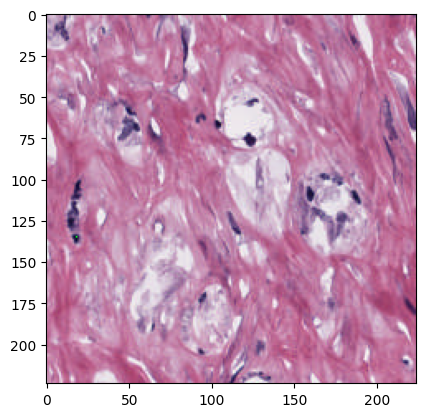

In [13]:
img = cv2.cvtColor(cv2.imread('../data/TCGA_breast_patch/TCGA-D8-A1XR-01A-01-T_R1/patch_13_4.png'), cv2.COLOR_BGR2RGB)
plt.imshow(img)

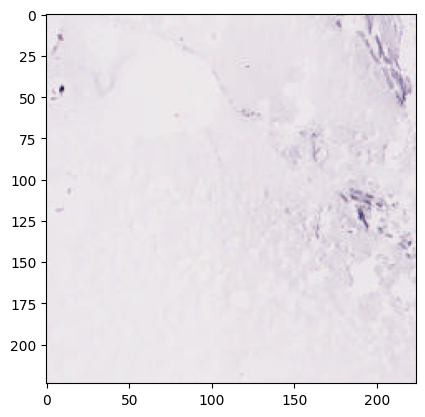

In [14]:
img = cv2.cvtColor(cv2.imread('../data/TCGA_breast_patch/TCGA-BH-A0H5-01A-02-B_R1/patch_11_5.png'), cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [15]:
from torchvision.models import resnet18, resnet50, ResNet18_Weights

def load_model_weights(model, weights):

    model_dict = model.state_dict()
    weights = {k: v for k, v in weights.items() if k in model_dict}
    if weights == {}:
        print('No weight could be loaded..')
    model_dict.update(weights)
    model.load_state_dict(model_dict)

    return model

model = resnet18()
state = torch.load('./tenpercent_resnet18.ckpt', map_location='cuda:0')
state_dict = state['state_dict']
for key in list(state_dict.keys()):
    state_dict[key.replace('model.', '').replace('resnet.', '')] = state_dict.pop(key)

model = load_model_weights(model, state_dict)
model = model.cuda()
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [16]:
augmented_train_df.head()

label  \
patient_id            file_name                                                  
TCGA-D8-A1XR-01A-01-T ../data/TCGA_breast_patch/TCGA-D8-A1XR-01A-01-T...   HR+   
                      ../data/TCGA_breast_patch/TCGA-D8-A1XR-01A-01-T...   HR+   
                      ../data/TCGA_breast_patch/TCGA-D8-A1XR-01A-01-T...   HR+   
                      ../data/TCGA_breast_patch/TCGA-D8-A1XR-01A-01-T...   HR+   
                      ../data/TCGA_breast_patch/TCGA-D8-A1XR-01A-01-T...   HR+   

                                                                                          patch_id  \
patient_id            file_name                                                                      
TCGA-D8-A1XR-01A-01-T ../data/TCGA_breast_patch/TCGA-D8-A1XR-01A-01-T...  TCGA-D8-A1XR-01A-01-T_R1   
                      ../data/TCGA_breast_patch/TCGA-D8-A1XR-01A-01-T...  TCGA-D8-A1XR-01A-01-T_R1   
                      ../data/TCGA_breast_patch/TCGA-D8-A1XR-01A-01-T...  TCGA-D8-A1XR-01A-01-T_R1   
                      ../data/TCGA_breast_patch/TCGA-D8-A1XR-01A-01-T...  TCGA-D8-A1XR-01A-01-T_R1   
                      ../data/TCGA_breast_patch/TCGA-D8-A1XR-01A-01-T...  TCGA-D8-A1XR-01A-01-T_R1   

                                                                         transform  
patient_id            file_name                                                     
TCGA-D8-A1XR-01A-01-T ../data/TCGA_breast_patch/TCGA-D8-A1XR-01A-01-T...      none  
                      ../data/TCGA_breast_patch/TCGA-D8-A1XR-01A-01-T...      none  
                      ../data/TCGA_breast_patch/TCGA-D8-A1XR-01A-01-T...      none  
                      ../data/TCGA_breast_patch/TCGA-D8-A1XR-01A-01-T...      none  
                      ../data/TCGA_breast_patch/TCGA-D8-A1XR-01A-01-T...      none

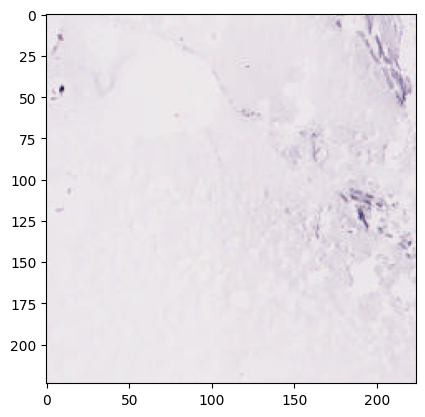

In [17]:
plt.imshow(np.asarray(img))

In [18]:
class Enhance:
    def __call__(self, pic):
        enhancer = ImageEnhance.Sharpness(pic)
        return enhancer.enhance(2)

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}()"

base_transforms = v2.Compose([
        v2.PILToTensor(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Resize((224, 224), antialias=True),
        v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

tensor_transforms = v2.Compose([
        v2.PILToTensor(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Resize((224, 224), antialias=True),
        v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

rotate_flip_transforms = v2.Compose([
    v2.PILToTensor(),
    v2.ToDtype(torch.float32, scale=True),
    v2.RandomRotation([90, 180]),
    v2.RandomHorizontalFlip(p=0.6),
    v2.RandomVerticalFlip(p=0.6),
    v2.Resize((224, 224), antialias=True),
    v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

class TCGABags(Dataset):
    def __init__(self, df, labels, model, bag_len=10, mean_bag_length=10, var_bag_length=1, num_bag=1000, seed=7, train=True, transform = base_transforms, num_of_clusters=20):
        self.transform = transform
        self.mean_bag_length = mean_bag_length
        self.var_bag_length = var_bag_length
        self.num_bag = num_bag
        self.seed = seed
        self.train = train
        self.df = df
        self.idx = df.index.get_level_values(0).unique()
        self.labels = labels
        self.bag_len = bag_len
        self.num_of_clusters = num_of_clusters
        self.model = model.cuda()
        self.transforms = {'bc': bc, 'hsv': hsv, 'hed': hed, 'morphology': morphology}
        # self.transforms = {'none': lambda x: x}

        self.r = np.random.RandomState(seed)

    def are_arrays_equal(self, arr):
        return (np.diff(np.vstack(arr).reshape(len(arr),-1),axis=0)==0).all()
    
    def get_transforms(self, transform_type):
        if transform_type != 'none':
            return rotate_flip_transforms
            # return base_transforms
        else: return base_transforms

    def __len__(self):
        return len(self.idx)
    
    def save_iteration_images(self, images, transform, batch_name, transform_type):
        res = []
        chunks_num = int(images.shape[0] / 200) + 1
        new_images = np.empty(images.shape)
        new_images[0] = images[0]
        final_transform = self.get_transforms(transform_type)
        for i in range(images.shape[0]):
            tmp = final_transform(self.transforms[transform](images[i]))
            new_images[i] = tmp
        new_images = new_images.transpose(0, 3, 2, 1)

        for img_chunk in np.array_split(new_images, chunks_num):
            img_chunk = torch.Tensor(img_chunk.astype(np.float32)).cuda()
            outputs = self.model(img_chunk)
            res.append(outputs.cpu().detach().numpy())
            # del img_chunk
            # del outputs
            torch.cuda.empty_cache()
        res = np.vstack(res)

        fname = f'../data/TCGA_features_resnet_nonorm/{transform}/{batch_name}.pt'
        if self.num_of_clusters <= images.shape[0]:
            kmeans = KMeans(n_clusters=self.num_of_clusters, random_state=0, n_init="auto").fit(res)
            torch.save(torch.from_numpy(kmeans.cluster_centers_), fname)
        else:
            torch.save(torch.from_numpy(res), fname)
    
    def __getitem__(self, index):
        batch = self.df.loc[self.idx[index]]
        label = self.labels.index(batch.iloc[0, 0])
        transform_type = batch.iloc[0, 2]
        
        images_arr = [tensor_transforms(Image.open(img_path)) for img_path in batch.index]
        images = (np.stack(images_arr, axis=0) * 255).astype(np.uint8).transpose(0, 2, 3, 1)

        for t in self.transforms.keys():
            self.save_iteration_images(images, t, self.idx[index], transform_type)
        return label, self.idx[index]
dl = DataLoader(TCGABags(augmented_train_df, ['HER2+', 'HR+', 'TNBC'], model),  batch_size=1)
label, index = next(iter(dl))

In [45]:
images_arr = [base_transforms(Image.open(img_path)) for img_path in augmented_train_df.loc['TCGA-D8-A1XR-01A-01-T'].index]
images = np.stack(images_arr, axis=0).astype(np.uint8).transpose(0, 2, 3, 1)
bc(images[0])

d:\jswietek\mgr\env\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


array([[[ 11,  40,  33],
        [  2,  10,   7],
        [  0,   3,  11],
        ...,
        [ 51, 118,  52],
        [127, 163,  51],
        [172, 191,  44]],

       [[ 35,  21,  13],
        [ 51,  34,  15],
        [ 47,  24,  31],
        ...,
        [ 56, 151,  44],
        [ 66, 172,  57],
        [ 61, 154,  41]],

       [[ 11,   2,   0],
        [  3,   5,   4],
        [  8,  18,  18],
        ...,
        [  8,  30,   7],
        [ 31, 126,  37],
        [ 41, 170,  69]],

       ...,

       [[ 10,  42,  19],
        [  3,  20,  35],
        [  1,   9,  30],
        ...,
        [ 17,  30,   7],
        [ 32,  14,  10],
        [ 26,  14,  43]],

       [[ 74,  41,   8],
        [ 23,  41,  14],
        [  6,  12,  10],
        ...,
        [ 19,  12,   9],
        [ 20,  12,  29],
        [  4,   5,   9]],

       [[  0,   3,  11],
        [  5,   5,   3],
        [ 23,   6,   2],
        ...,
        [  8,   4,   0],
        [ 27,  12,  11],
        [ 12,  35,  55]]

In [15]:
class TimmCNNEncoder(torch.nn.Module):
    def __init__(self, model_name: str = 'resnet50.tv_in1k', 
                 kwargs: dict = {'features_only': True, 'out_indices': (3,), 'pretrained': True, 'num_classes': 3}, 
                 pool: bool = True):
        super().__init__()
        assert kwargs.get('pretrained', False), 'only pretrained models are supported'
        self.model = timm.create_model(model_name, **kwargs)
        self.model_name = model_name
        if pool:
            self.pool = torch.nn.AdaptiveAvgPool2d(1)
        else:
            self.pool = None
    
    def forward(self, x):
        out = self.model(x)
        if isinstance(out, list):
            assert len(out) == 1
            out = out[0]
        if self.pool:
            out = self.pool(out).squeeze(-1).squeeze(-1)
        return out

In [19]:
from tqdm import tqdm
device = 'cuda:0'
# timm_model = TimmCNNEncoder().to(device)
train_dataset = TCGABags(augmented_train_df, ['HER2+', 'HR+', 'TNBC'], model, num_of_clusters=20)
train_dl = DataLoader(train_dataset, batch_size=1)

test_dataset = TCGABags(test_df, ['HER2+', 'HR+', 'TNBC'], model, num_of_clusters=20)
test_dl = DataLoader(test_dataset, batch_size=1)

for i, (label, index) in tqdm(enumerate(train_dl), total=len(train_dl)):
    continue

100%|██████████| 1596/1596 [47:28:37<00:00, 107.09s/it]   


In [20]:
for i, (label, index) in tqdm(enumerate(test_dl), total=len(test_dl)):
    continue

100%|██████████| 226/226 [22:37<00:00,  6.01s/it]
